# Conformer generator

In [19]:
import veloxchem as vlx

## Systematic Search

We define a structure by using a SMILES string.

In [20]:
molecule = vlx.Molecule.read_smiles(
    "CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C"
)  # this is SMILES for Penicillin G
molecule.show(atom_indices=True)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

ConformerGenerator class can generate all possible conformations and apply energy minimization process with MMforcefield

In [21]:
conf = vlx.ConformerGenerator()
conformers_dict = conf.generate(molecule)

***********                                                                                                               
* Warning * ConformerGenerator: Partial charges not provided. Will use a quick (and likely inaccurate) estimation of partial charges.
***********                                                                                                               
* Info * 36 conformers will be generated.                                                                                 
* Info * 36 conformers generated in 0.34 sec                                                                              
* Info * Energy minimization of 36 conformers took 1.17 sec                                                               
* Info * Global minimum energy: -48.712 kJ/mol                                                                            
* Info * 6 conformers remain after removal of duplicate conformers.                                                       
* Inf

show the lowest energy conformer

In [22]:
conf.show_global_minimum()

Global minimum conformer with energy -48.712 kJ/mol


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

 show more conformers

In [23]:
conf.show_conformers(number=3, atom_indices=True)

Conformer 1 with energy -48.712 kJ/mol


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Conformer 2 with energy -43.657 kJ/mol


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Conformer 3 with energy -42.234 kJ/mol


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

we can provide resp charges as partial charges to improve the used MMforcefield quality

In [24]:
basis = vlx.MolecularBasis.read(molecule, "6-31g*")
resp = vlx.RespChargesDriver()
resp.ostream.mute()
partial_charges = resp.compute(molecule, basis, 'resp')

In [25]:
conf = vlx.ConformerGenerator()
conf.partial_charges = partial_charges
conformers_dict = conf.generate(molecule)
conf.show_global_minimum(atom_indices=True)

* Info * 36 conformers will be generated.                                                                                 
* Info * 36 conformers generated in 0.34 sec                                                                              
* Info * Energy minimization of 36 conformers took 1.46 sec                                                               
* Info * Global minimum energy: -102.772 kJ/mol                                                                           
* Info * 3 conformers remain after removal of duplicate conformers.                                                       
* Info * Total time spent in generating conformers: 1.97 sec                                                              
Global minimum conformer with energy -102.772 kJ/mol


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

we can apply implicit solvent model for the energy minimization 

In [26]:
conf = vlx.ConformerGenerator()
conf.ostream.mute()
conf.show_available_implicit_solvent_models()
conf.implicit_solvent_model = "hct"  #here we set Hawkins-Cramer-Truhlar GBSA model
conformers_dict = conf.generate(molecule)
conf.show_global_minimum(atom_indices=True)

Available implicit solvent files:
gbn.xml
hct.xml
obc1.xml
gbn2.xml
obc2.xml
Global minimum conformer with energy -125.047 kJ/mol


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

show more conformers

In [27]:
conf.show_conformers(number=3, atom_indices=True)

Conformer 1 with energy -125.047 kJ/mol


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Conformer 2 with energy -122.810 kJ/mol


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Conformer 3 with energy -120.466 kJ/mol


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Extract conformers from an MD simulation

Using the OpenMMDynamics class, we can perform Molecular Dynamics

In [28]:
molecule = vlx.Molecule.read_xyz_file("data/tq-polymer.xyz")
molecule.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

The next cell is used to calculate RESP charges for the system. However, since this calculation is time consuming, the next cell is commented and the partial charges are provided in the following cell.

In [29]:
#basis = vlx.MolecularBasis.read(molecule, "6-31g*")
#resp = vlx.RespChargesDriver()
#partial_charges = resp.compute(molecule, basis, 'resp')
#print(partial_charges)

In [30]:
partial_charges = [
 -0.23266931, -0.04823439, -0.00768593,  0.10018278,  0.38698743, -0.24945099,
  0.19495109,  0.11467828,  0.06236094,  0.00542244, -0.10766019, -0.1982617,
  0.01620013, -0.09032384, -0.23529148,  0.06213728,  0.419456,   -0.53179623,
  0.13900773,  0.16411472, -0.08606877, -0.04451295,  0.19955552, -0.17029552,
 -0.18015684, -0.1133219,   0.15810609, -0.08196562, -0.12877407, -0.23955694,
 -0.13677057,  0.30158162, -0.20301966,  0.13834221,  0.13658744, -0.31694833,
 -0.03182647,  0.13715376,  0.11899939,  0.16192621,  0.13063207,  0.17382562,
 -0.33276051, -0.00577005,  0.07952667,  0.07952667,  0.06596162,  0.06596162,
 -0.24208522, -0.08746283,  0.0129347,   0.06150182,  0.2660882,  -0.00111437,
  0.1037246,   0.18094784,  0.01584349, -0.12325936, -0.24250448,  0.0561585,
 -0.11800886, -0.24794804,  0.19611705,  0.20539002, -0.29892928,  0.08487697,
  0.07952667,  0.1582663,  -0.14684433, -0.04075369,  0.25102047, -0.20320982,
 -0.16058414, -0.15306783,  0.1592547,  -0.05293313, -0.11907114, -0.24842299,
 -0.07940933,  0.16146974, -0.13494737,  0.14994106,  0.17097986, -0.32427475,
 -0.04223001,  0.07723726,  0.14478107,  0.11187124,  0.14649411,  0.11846808,
 -0.25956843, -0.02044809,  0.07970686,  0.07970686,  0.06516478,  0.06516478,
  0.06596162,  0.06516478,  0.07970686,  0.09127322, -0.25771988, -0.06133307,
  0.00628985,  0.05371858,  0.24153917,  0.00827491,  0.17754439,  0.13668706,
  0.10222654,  0.03680489, -0.16795552, -0.17000726,  0.02669681, -0.12172821,
 -0.21900063,  0.17946952,  0.21890735, -0.26948284,  0.1307234,   0.16949918,
 -0.14124631, -0.0455031,   0.23159166, -0.20306447, -0.14909185, -0.16035176,
  0.15687754, -0.0872775,  -0.1172997,  -0.25351842, -0.10566528,  0.20167734,
 -0.12919819,  0.1543798,   0.14441411, -0.31155974, -0.05033539,  0.16950455,
  0.11780647,  0.07857705,  0.10483532,  0.17792367, -0.27772352, -0.03088794,
  0.08387225,  0.08387225,  0.07119718,  0.07119718, -0.20549054, -0.10532521,
  0.00421472,  0.07138742,  0.20521205,  0.00254779,  0.10055996,  0.15866661,
  0.02119777, -0.10911502, -0.25854617,  0.07127077, -0.13791094, -0.23129747,
  0.15085068,  0.2326047,  -0.25590149,  0.06940969,  0.08387225,  0.16521633,
 -0.1180965,  -0.03505999,  0.23236288, -0.19948191, -0.16018508, -0.16360577,
  0.15990844, -0.07566072, -0.11905997, -0.25587181, -0.09917076,  0.21117113,
 -0.1462551,   0.16789654,  0.17662302, -0.31282512, -0.05987767,  0.07244333,
  0.1448517,   0.11948185,  0.15238884,  0.11592778, -0.28891858, -0.02312194,
  0.08487697,  0.08487697,  0.06983536,  0.06983536,  0.07119718,  0.06983536,
 -0.27716358, -0.03892087,  0.00205159,  0.07613822,  0.22040262,  0.00877301,
  0.18655541,  0.12204191,  0.06412381,  0.00680683, -0.10245549, -0.21171259,
  0.02552486, -0.10086527, -0.22571082,  0.13445803,  0.22085514, -0.23984174,
  0.14648149,  0.15746908, -0.08463626, -0.0387884,   0.19111359, -0.16749491,
 -0.17388606, -0.13936101,  0.15812357, -0.1156188,  -0.11083203, -0.246506,
 -0.11169709,  0.20025464, -0.10272807,  0.14702152,  0.13701896, -0.31140134,
 -0.028076,    0.15791607,  0.12185364,  0.07094104,  0.09720876,  0.17483523,
 -0.27773091, -0.05849781,  0.07847028,  0.07847028,  0.07965025,  0.07965025,
 -0.2397521,  -0.09341684,  0.01339525,  0.06572247,  0.25223365,  0.002507,
  0.0971417,   0.1764116,   0.01229505, -0.10991864, -0.25322248,  0.06251399,
 -0.12133834, -0.23921695,  0.17999001,  0.22526708, -0.29359387,  0.08440681,
  0.07847028,  0.16337351, -0.1565546,  -0.02789087,  0.26708614, -0.22016262,
 -0.153943,   -0.13833183,  0.15652409, -0.06827389, -0.10775748, -0.24864989,
 -0.08373426,  0.15061831, -0.12887559,  0.15591585,  0.17180216, -0.33258253,
 -0.03331989,  0.07149245,  0.14767803,  0.11457325,  0.14026477,  0.11530703,
 -0.24902146, -0.02827871,  0.07707418,  0.07707418,  0.06819106,  0.06819106,
  0.07965025,  0.06819106,  0.07707418,  0.0856175,  -0.26218085, -0.0584246,
  0.00456722,  0.05438889,  0.24586499,  0.00696626,  0.1783569,   0.13400676,
  0.09799985,  0.03125357, -0.15219288, -0.17224799,  0.02445693, -0.11439113,
 -0.2183541,   0.18323659,  0.21156225, -0.27398977,  0.12528358,  0.15865568,
 -0.14406467, -0.0335401,   0.21621824, -0.18858059, -0.15528425, -0.15780651,
  0.15619853, -0.07885735, -0.11741123, -0.25461025, -0.09799056,  0.19892431,
 -0.13319181,  0.15309207,  0.14200536, -0.30665031, -0.07147721,  0.1685966,
  0.11397887,  0.07505986,  0.10796149,  0.17738219, -0.28183042, -0.02292667,
  0.09264957,  0.09264957,  0.06940969,  0.06940969, -0.23482396, -0.08827898,
 -0.01061006,  0.09810372,  0.2357452,  -0.0032367,   0.09191832,  0.18103926,
 -0.03320309, -0.00719868, -0.31403912, -0.12158504, -0.06412926, -0.26903382,
  0.18144415,  0.22231257, -0.28254811,  0.20002985,  0.09264957,  0.1755563,
 -0.12479992, -0.03303722,  0.24295814, -0.20574671, -0.15709583, -0.15187858,
  0.15871935, -0.06157348, -0.11232057, -0.25093591, -0.10330636,  0.19475989,
 -0.13726105,  0.15152399,  0.17552223, -0.32088829, -0.04892549,  0.06981638,
  0.1464772,   0.12144991,  0.1417967,   0.11573457, -0.28201561, -0.02604886,
  0.08440681,  0.08440681,  0.07094104,  0.07094104]

In the next cell, we are using the partial charges to derive a Force-Field using the MMForceFieldGenerator class.

In [31]:
ff_gen = vlx.MMForceFieldGenerator()
ff_gen.partial_charges = partial_charges
ff_gen.create_topology(molecule)


* Info * Sum of partial charges is not a whole number.                                                                    
* Info * Compensating by removing 3.000e-06 from the largest charge.                                                      
                                                                                                                          
* Info * Using GAFF (v2.11) parameters.                                                                                   
         Reference: J. Wang, R. M. Wolf, J. W. Caldwell, P. A. Kollman, D. A. Case, J. Comput. Chem. 2004,
         25, 1157-1174.
                                                                                                                          
* Info * Updated bond length 10-14 (cc-ss) to 0.169 nm                                                                    
* Info * Updated bond length 13-14 (cc-ss) to 0.168 nm                                                                    
* Info *

Once a force field is derived, different functions can be used which use the OpenMM library to perform molecular dynamics simulations. This is available in the OpenMMDynamics class. The next cell gives an example how to run a MD.

In [32]:
opm_dyn = vlx.OpenMMDynamics()
opm_dyn.create_system_from_molecule(molecule,
                                    ff_gen,
                                    filename='tq-polymer',
                                    residue_name='MOL')
opm_dyn.run_md(
            ensemble='NVE',
            temperature=300, 
            timestep=2.0, 
            nsteps=100000, 
            traj_file='tq_polymer_md.pdb')

* Info * System parameters written to tq-polymer_system.xml                                                               
* Info * System coordinates written to tq-polymer_system.pdb                                                              
MD Simulation parameters:
Ensemble: NVE
Friction: 1.0 1/ps
Timestep: 2.0 fs
Total simulation time in ns: 0.2
Step: 0 / 100000 Time: 0.0 ps
Potential Energy 1635.3257823586464 kJ/mol
Kinetic Energy: 0.03257686317442676 kJ/mol
Temperature: 0.007563891995932361 K
Total Energy: 1635.3583592218208 kJ/mol
------------------------------------------------------------
Step: 1000 / 100000 Time: 2.0 ps
Potential Energy 1633.3816247880459 kJ/mol
Kinetic Energy: 1.9764162392020808 kJ/mol
Temperature: 0.4588962077867221 K
Total Energy: 1635.358041027248 kJ/mol
------------------------------------------------------------
Step: 2000 / 100000 Time: 4.0 ps
Potential Energy 1633.44306153059 kJ/mol
Kinetic Energy: 1.9160925478349782 kJ/mol
Temperature: 0.444889890

Moreover, we have developed a function to extract conformers from the MD simulation at high temperature. The user can define a number of snapshots that will be optimized and save. In addition, those snapshots can be filtered to avoid that the same conformer is present multiple timess by using the option unique_conformers.

In [33]:
conformers_dict = opm_dyn.conformational_sampling(
                                ensemble='NVT', 
                                temperature=1000, 
                                timestep=2.0, 
                                nsteps=1000000, 
                                snapshots=5000,
                                unique_conformers=True,
                                qm_driver=None,
                                basis=None,
                                constraints=None)

* Info * Minimized energy: 1648.078935533762                                                                              
* Info * Saved coordinates for step 200                                                                                   
* Info * Minimized energy: 1650.2746507823467                                                                             
* Info * Saved coordinates for step 400                                                                                   
* Info * Minimized energy: 1686.890348225832                                                                              
* Info * Saved coordinates for step 600                                                                                   
* Info * Minimized energy: 1687.1797451376915                                                                             
* Info * Saved coordinates for step 800                                                                                   
* Info * Minimiz

In [37]:
opm_dyn.show_conformers(number=10)

* Info * 
Conformation 1: Energy: 1580.988 kJ/mol, Weight: 0.3839                                                         


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

* Info * 
Conformation 2: Energy: 1582.025 kJ/mol, Weight: 0.2532                                                         


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

* Info * 
Conformation 3: Energy: 1582.726 kJ/mol, Weight: 0.1912                                                         


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

* Info * 
Conformation 4: Energy: 1584.486 kJ/mol, Weight: 0.0944                                                         


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

* Info * 
Conformation 5: Energy: 1587.214 kJ/mol, Weight: 0.0316                                                         


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

* Info * 
Conformation 6: Energy: 1588.032 kJ/mol, Weight: 0.0228                                                         


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

* Info * 
Conformation 7: Energy: 1590.287 kJ/mol, Weight: 0.0092                                                         


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

* Info * 
Conformation 8: Energy: 1590.475 kJ/mol, Weight: 0.0086                                                         


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

* Info * 
Conformation 9: Energy: 1595.421 kJ/mol, Weight: 0.0012                                                         


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

* Info * 
Conformation 10: Energy: 1595.968 kJ/mol, Weight: 0.0009                                                        


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

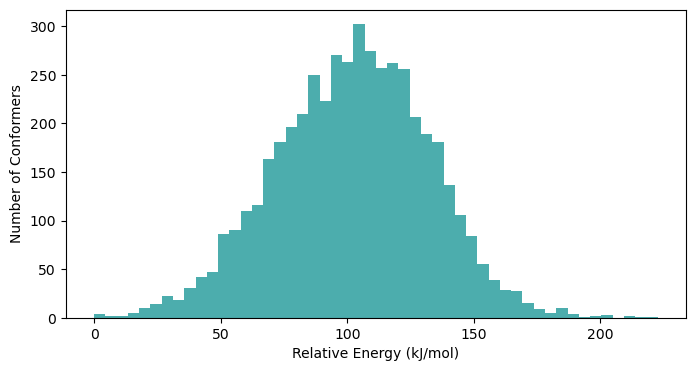

In [35]:
# plot the distribution of the relative energies of the conformers
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(conformers_dict['energies']-np.min(conformers_dict['energies']),
        bins=50, 
        color='darkcyan', 
        alpha=0.7)
plt.xlabel('Relative Energy (kJ/mol)')
plt.ylabel('Number of Conformers')

plt.savefig('conformer_energy_distribution.pdf')
plt.show()


In [36]:
# show the most stable conformer and write it to an XYZ file
conformers_dict['molecules'][0].show()
conformers_dict['molecules'][0].write_xyz_file('tq-polymer-0.xyz')


3Dmol.js failed to load for some reason. Please check your browser console for error messages.